In [1]:
using JLD2
using PyPlot
using StatsBase # Statistics

using ScikitLearn # machine learning package
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

using PyCall
@pyimport matplotlib.animation as anim

# config plot settings
PyPlot.matplotlib.style.use("ggplot")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [2]:
@load joinpath(pwd(), "targets_and_normalized_features.jld2") X henry_y gcmc_y

3-element Vector{Symbol}:
 :X
 :henry_y
 :gcmc_y

## BO Function

In [3]:
### procedure:
# 1. select initial COF identifiers set to train GP 
# 2. initialize and normalize array of initial target data 
# 3. itterate through budgetted number of BO runs
#    a. construct GP model with kernel
#    b. fit GP to current data for acquired COFs => gives ŷ(x)
#    c. construct acquiaition function A(x)
#    d. determine which COF to acquire next => evaluate argmax(A(x))
#       i. for EI track if this is an exploitation or an exploration
#    e. append COF identified in step 3.d to list of acquired COFs 
# 4. update final set of acquired COF data and normalize
# 5. return the IDs for the set of acquired COFs
###
function run_bayesian_optimization(X, y, nb_iterations::Int, 
                                   nb_COFs_initialization::Int;
                                   which_acquisition::Symbol=:UCB,
                                   store_explore_exploit_terms::Bool=false,
                                   sample_gp::Bool=false,
                                   initialize_with::Union{Array{Int, 1}, Nothing}=nothing)
    # quick checks
    @assert nb_iterations > nb_COFs_initialization "More initializations than itterations not allowed."
    @assert which_acquisition in [:UCB] "Acquisition function not supported:\t $(which_acquisition)"
    
    # create array to store explore-explot terms if needed
    if store_explore_exploit_terms
        explore_exploit_balance = []
    end
    
    if sample_gp
        store_sample_y = []
    end
    
    ###
    #  1. randomly select COF IDs for training initial GP
    ###
    if isnothing(initialize_with)
        ids_acquired = StatsBase.sample(1:nb_COFs, nb_COFs_initialization, replace=false)
        @assert length(unique(ids_acquired)) == nb_COFs_initialization
    else
        # initialize using a specified set of indecies
        ids_acquired = initialize_with
        @assert length(unique(ids_acquired)) == nb_COFs_initialization
    end
     
    ###
    #  3. itterate through budgetted number of BO runs
    ###
    for i in range(nb_COFs_initialization, stop=nb_iterations)
        ###
        #  a-b. construct and fit GP model
        ###
        kernel = Matern(nu=2.5, length_scale=0.25) 
        model = GaussianProcessRegressor(kernel=kernel, normalize_y=true, n_restarts_optimizer=5)
        model.fit(X[ids_acquired, :], y[ids_acquired])
        
        if sample_gp
            sample_y = model.sample_y(X)
            push!(store_sample_y, sample_y)
        end
        
        ###
        #  c. setup acquisition function
        ###
        if which_acquisition == :UCB
            # A(x) = ŷ(x) + βσ(x)
            # where β controlls exploitation-exploration trade-off
            β = 2.0
            ŷ, σ = model.predict(X, return_std=true)
            acquisition_values = ŷ .+ β * σ
        elseif which_acquisition == :EI
            # A(x) = integral{-∞}{+∞}[I(x)N(y|ŷ(x), σ²(x))dy]
            # where I(x) = max(0, f(x) - maxᵢ(yᵢ))
        end
        
        ###
        #  d. determine which COF to acquire next
        ###
        ids_sorted_by_aquisition = sortperm(acquisition_values, rev=true)
        for id_max_aquisition in ids_sorted_by_aquisition
            if ! (id_max_aquisition in ids_acquired)
                ###
                #  e. acqurie this COF (i.e. update list)
                ###
                push!(ids_acquired, id_max_aquisition)
                if store_explore_exploit_terms
                    # store explore and exploit terms
                    push!(explore_exploit_balance, [ŷ[id_max_aquisition], β * σ[id_max_aquisition]])
                end
                break
            end
        end
        # quick check
        @assert length(ids_acquired) == i + 1
    end
    
    # quick check (remember to account for final COF to be acquired)
    @assert length(ids_acquired) == nb_iterations + 1 "length(ids_acquired) = $(length(ids_acquired))"
    
    ###
    #  5. return the IDs for the set of acquired COFs
    ###
    if sample_gp
        return ids_acquired, explore_exploit_balance, store_sample_y
    else
        return ids_acquired, explore_exploit_balance
    end
end

run_bayesian_optimization (generic function with 1 method)

## Apply BO

In [4]:
###
#  Find COF located nearest the center of the feature space
###
min = sum(ones(Float64, length(X[1, :]))) # max possible value of normalized features
id_min = 0
com = 0.5 * ones(Float64, length(X[1, :])) # center of normalized feature space

for i in 1:length(X[:, 1])
    dist = sqrt(sum((X[i, :] .- com).^2))
    if dist < min
        min = dist
        id_min = i
    end
end
id_min, min

(26, 1.2041567193979834)

In [5]:
nb_COFs = length(gcmc_y)
nb_iterations = 150
nb_COFs_initialization = 1
which_acquisition = :UCB 

# try to initialize using a COF that is close to the center of the domain (feature space)
initialize_with = [id_min]

1-element Vector{Int64}:
 26

In [6]:
ucb_ids, ucb_eeb, sample_y = run_bayesian_optimization(X, gcmc_y, nb_iterations, 
                                             nb_COFs_initialization;
                                             which_acquisition=:UCB,
                                             store_explore_exploit_terms=true,
                                             sample_gp=true,
                                             initialize_with=initialize_with);

## search efficiency curve

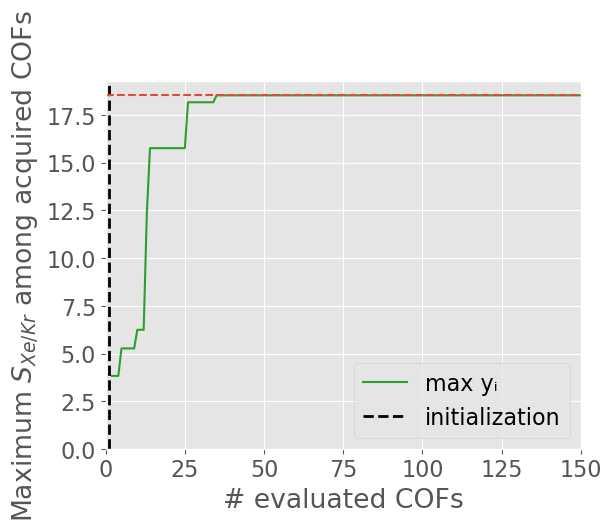

In [7]:
# plot maximum selectivity among acquired COFs as a function of the number of COFs acquired (itterations)
index = zeros(Int64, length(ucb_ids))
max_selectivity = zeros(Float64, length(ucb_ids))
for i in 1:length(ucb_ids)
    ids = ucb_ids[1:i]
    max_y = maximum(gcmc_y[ids])
    max_selectivity[i] = max_y
    ittration = i + nb_COFs_initialization
    index[i] = ittration
end

figure()
plot(index, max_selectivity, label="max yᵢ", color="tab:green")
axvline(x=nb_COFs_initialization, label="initialization", color="k", linestyle="--", lw=2)

axhline(y=maximum(gcmc_y), linestyle="--")

legend(loc="lower right")
xlabel("# evaluated COFs")
ylabel("Maximum " * L"S_{Xe/Kr}" * " among acquired COFs")
xlim([0.0, nb_iterations])
ylim(ymin=0.0)

tight_layout()
savefig(joinpath(pwd(), "search_efficientcy_curve.png"), dpi=600, format="png")

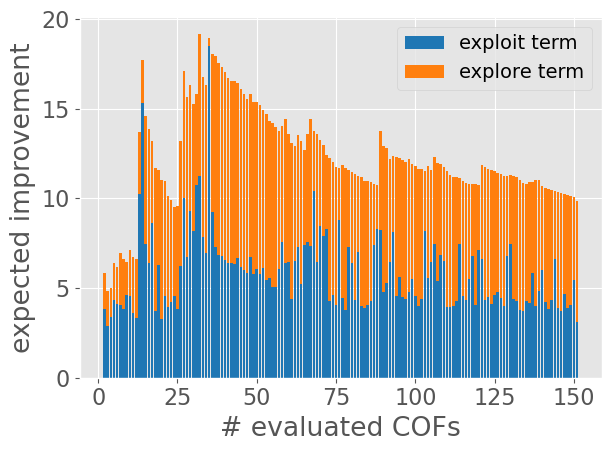

In [8]:
# make a plot of ŷ and σ as a function of itterations to see exploitation vs exploration
fig, axs = subplots()

index = [i + nb_COFs_initialization for i in nb_COFs_initialization:nb_iterations]
y = [ucb_eeb[i][1] for i in 1:length(ucb_eeb)]
σ = [ucb_eeb[i][2] for i in 1:length(ucb_eeb)]
axs.bar(index, y, label="exploit term", color="tab:blue", linestyle="--")
axs.bar(index, σ, label="explore term", color="tab:orange", bottom=y)

# axs.scatter(index, y .+ σ, label="EI", marker=".", facecolor="none", edgecolor="k")

axs.legend(fontsize=14)
axs.set_xlabel("# evaluated COFs")
axs.set_ylabel("expected improvement")

tight_layout()
savefig(joinpath(pwd(), "exploration_exploitation_balance.png"), dpi=600, format="png")

In [ ]:
# function showanim(filename)
#     base64_video = base64encode(open(filename))
#     display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
# end

# fig = figure(figsize=(4,4))
# ax = axes()

# x = [0:0.01:2pi;]

# # i=0,1,...,frames-1
# function animate(i)
#     clf()
#     plot(sin.(x+i/10.0))
# end

# function init()
#     plot(x,sin.(x))
# end

# withfig(fig) do
#     myanim = anim.FuncAnimation(fig, animate, frames=200, init_func=init, interval=25, blit=true)
#     myanim[:save]("test3.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
# end

# showanim("test3.mp4")

In [ ]:
###
#  make a plot of the sampled GP at each iteration
###
fig = figure(figsize=(12, 3))
axs = axes()

ind = [i for i in 1:length(sample_y[1])] # domain

function animate(i::Int)
    clf() # clear figure
    plot(ind, sample_y[i])
end

function init()
    plot(ind, sample_y[1])
end

withfig(fig) do
    myanim = anim.FuncAnimation(fig, animate, frames=200, init_func=init, interval=25, blit=true)
    myanim[:save]("test3.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end


xlabel("COF index")
ylabel("sample function value")

tight_layout()

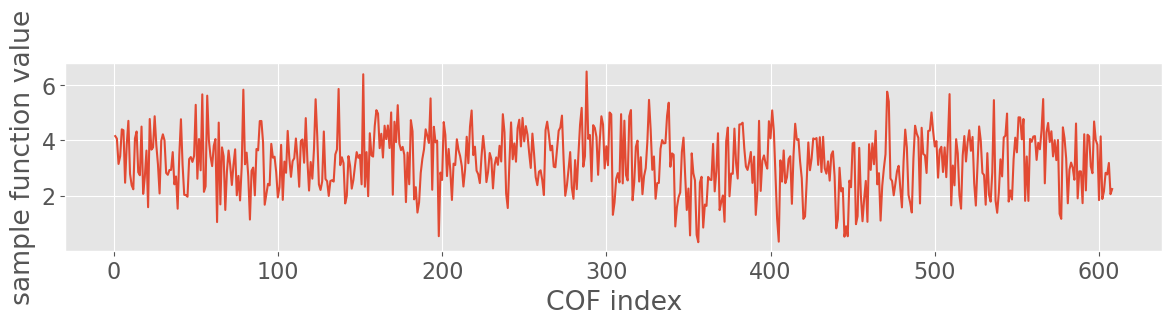

In [9]:
###
#  make a plot of the sampled GP at each iteration
###
figure(figsize=(12, 3))

ind = [i for i in 1:length(sample_y[1])]
plot(ind, sample_y[1])

xlabel("COF index")
ylabel("sample function value")

tight_layout()